<a href="https://colab.research.google.com/github/Deviantkay/SkripsiFIX/blob/main/SKRIPSI_FIX_BANGET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bagian 1: Instalasi Dependensi

In [ ]:
from tqdm import tqdm
import subprocess

packages = ["pysastrawi", "swifter", "joblib", "imbalanced-learn"]

with tqdm(total=len(packages), desc="Installing", unit="pkg") as pbar:
    for package in packages:
        tqdm.write(f"\n🔹 Installing {package}...")
        subprocess.run(["pip", "install", package, "--quiet"])
        pbar.update(1)


Installing:   0%|          | 0/4 [00:00<?, ?pkg/s]


🔹 Installing pysastrawi...


Installing:  25%|██▌       | 1/4 [00:04<00:12,  4.15s/pkg]


🔹 Installing swifter...


Installing:  50%|█████     | 2/4 [00:06<00:06,  3.36s/pkg]


🔹 Installing joblib...


Installing:  75%|███████▌  | 3/4 [00:09<00:03,  3.02s/pkg]


🔹 Installing imbalanced-learn...


Installing: 100%|██████████| 4/4 [00:12<00:00,  3.07s/pkg]


# Bagian 2: Import Libraries

In [ ]:
# 2.1 Standard Libraries
import contextlib
import os
import re
import string
import time
from collections import Counter

# 2.2 Third-party Libraries
import IPython.utils.io
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import swifter
import torch

# 2.3 Scientific & Statistical Computing
from scipy import stats

# 2.4 NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud

# 2.5 Machine Learning & Feature Extraction
from sklearn.decomposition import PCA  # Dimensionality reduction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC

# 2.6 Imbalanced Learning
from imblearn.over_sampling import SMOTE

# 2.7 Transformers for Deep Learning Models
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# 2.8 Google Colab Integration (For accessing Google Drive)
from google.colab import drive

# Download necessary NLTK resources
nltk_packages = ["stopwords", "punkt_tab"]

for package in nltk_packages:
    nltk.download(package)
    print(f"✔️ {package} downloaded successfully!")



✔️ stopwords downloaded successfully!



✔️ punkt_tab downloaded successfully!


In [ ]:
# Proses mounting dengan tampilan loading
for _ in tqdm(range(1), desc="🔄 Mounting Google Drive", unit="task"):
    print("\n⏳ Mounting Google Drive...")
    with IPython.utils.io.capture_output() as captured:
        drive.mount('/content/drive', force_remount=True)
        DATASET_PATH = "/content/drive/MyDrive/SkripsiFIX/Dataset/FixCrawling.xlsx"
    time.sleep(1)

# Tampilkan pesan sukses
print("\n✔️ Google Drive successfully mounted!")
print("📂 Dataset Path: /content/drive/MyDrive/SkripsiFIX/Dataset/FixCrawling.xlsx")

🔄 Mounting Google Drive:   0%|          | 0/1 [00:00<?, ?task/s]


⏳ Mounting Google Drive...


🔄 Mounting Google Drive: 100%|██████████| 1/1 [00:03<00:00,  3.66s/task]


✔️ Google Drive successfully mounted!
📂 Dataset Path: /content/drive/MyDrive/SkripsiFIX/Dataset/FixCrawling.xlsx


In [ ]:
# Load the dataset into a DataFrame
df = pd.read_excel(DATASET_PATH)

# Convert 'created_at' to datetime format
df['created_at'] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S +0000 %Y', errors='coerce')

# Save the initial DataFrame for comparison
df_initial = df.copy()

# Date filtering with timezone fix
df = df[(df['created_at'] >= '2023-12-01') & (df['created_at'] <= '2024-02-28')]

# Check if 'created_at' is timezone-aware before removing timezone
if df['created_at'].dt.tz is not None:
    df['created_at'] = df['created_at'].dt.tz_localize(None)  # Remove timezone info if it exists

# Display the DataFrame
df_head = df.head(10)
df_tail = df.tail(10)

# Tambahkan satu baris sebagai separator
df_separator = pd.DataFrame([["..."] * len(df.columns)], columns=df.columns)
df_separator.index = ["..."]

# Gabungkan dataframe tanpa mereset index
df_display = pd.concat([df_head, df_separator, df_tail])

# Styling tabel agar lebih rapi
df_display.style.set_properties(**{
    'border': '1px solid black',
    'text-align': 'center'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f4f4f4'), ('color', 'black'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('padding', '5px')]}
])


,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,Sentimen
0,1736756982693134080.000000,2023-12-18 14:35:06,0.000000,Berrti Gemoy & joget2 jgn diangkat lg y oleh TKN dan Paslon. Itu baliho2 pakai AI jg jgn pakai (minimal ad tulisan: gambar hanya ilustrasi bukan asli). Eh tp emang programnya pk Prabowo ap yg dgagas? Klo bagi makan siang itu jg trnyata program pk Anies dlu saat jd Gubernur jkt.,1736756982693134080.000000,nan,nan,in,nan,0.000000,0.000000,0.000000,https://x.com/Aryanto0402/status/1736756982693134428,1201105903782511104.000000,Aryanto0402,Negative
1,1737081538511254016.000000,2023-12-19 12:04:46,2.000000,Padahal dulu cita2 guee klo gambar gue udah level sepuh mau bikin style kombinasi fashion kyk ginii tapii udh telat keduluan sama AI https://t.co/HY5J5X1pwk,1737081538511254016.000000,https://pbs.twimg.com/media/GBtacvIbEAAJttr.jpg,nan,in,icon by @pretemdeer,0.000000,0.000000,0.000000,https://x.com/Mochiibakw1/status/1737081538511253751,1427482742652956928.000000,Mochiibakw1,Negative
2,1737117594455547904.000000,2023-12-19 14:28:03,5.000000,enak ya cuma jual jasa bikin gambar pake ai harganya 50k https://t.co/u9WaCSxMSo,1737117594455547904.000000,https://pbs.twimg.com/media/GBt7Jl4aEAAa5rm.jpg,nan,in,she/her,0.000000,1.000000,0.000000,https://x.com/kuecubitit/status/1737117594455548371,1293270098648550912.000000,kuecubitit,Negative
3,1737225327792001024.000000,2023-12-19 21:36:08,0.000000,Padahal gambar editan AI itu khas bngt kok pada percaya,1737225327792001024.000000,nan,nan,in,nan,0.000000,0.000000,0.000000,https://x.com/A2N012/status/1737225327792001083,1663958875358499072.000000,A2N012,Negative
4,1737271297254859008.000000,2023-12-20 00:38:48,1.000000,masih sedih liat orang yang kuhormati di bidang lain (matematika bahasa psikologi sejarah dll) dengan gampangnya pakai gambar hasil AI... pada nggak tahu apa sengaja ya? kalau nggak tahu kira-kira gimana cara menyampaikan ke masyarakat umum dengan jelas dan mudah dipahami?,1737271297254859008.000000,nan,nan,in,nan,0.000000,1.000000,0.000000,https://x.com/notdaydriiim/status/1737271297254859082,1086050607150951936.000000,notdaydriiim,Negative
5,1737298035489878016.000000,2023-12-20 02:25:03,0.000000,Materi diklat hari ini ngebahas manfaat ai eughh pengen muntah malah disaranin pake buat bikin gambar dll ya ampun pengen tutup kuping,1737298035489878016.000000,nan,nan,in,about me/yume intro ⬇️,0.000000,0.000000,0.000000,https://x.com/groshia_/status/1737298035489878330,550777908.000000,groshia_,Negative
6,1737277542053327104.000000,2023-12-20 03:36:26,0.000000,@thethreatboy @louserinaa @coock1es @caturaperkasa Yaa ada oknum yang menggunakan gambar spt itu jadi sama AI nya di learning juga. Harusnya AI nya dibatasin juga utk gambar spt itu auto decline,1737315997592535040.000000,nan,thethreatboy,in,"Kota Surabaya, Jawa Timur",0.000000,0.000000,0.000000,https://x.com/ExCommunicad/status/1737315997592535374,1125738973328920960.000000,ExCommunicad,Negative
7,1737319312204197888.000000,2023-12-20 03:59:01,0.000000,@artistsbase Soalnya Ai tuh vector based nder biasa dipake buat graphic design gambar disitu ga bakal pecah waktu dicetak ukuran gede. kalo csp photoshop medibang ibis itu kan raster/bitmap jadi ada pixelnya,1737321681390359040.000000,nan,artistsbase,in,mars,0.000000,1.000000,0.000000,https://x.com/kiyuuzy/status/1737321681390358722,1460909404933423104.000000,kiyuuzy,Negative
8,1737319312204197888.000000,2023-12-20 04:00:20,0.000000,@artistsbase Ayo nder gambar di Ai wkwk seru kok dan karena dia based-nya vektor jadi gak perlu khawatir masalah gambar pecah cuma perlu diperhatiin aja size pas exportnya,1737322015001136896.000000,nan,artistsbase,in,Indonesia,0.000000,0.000000,0.000000,https://x.com/nothofogus/status/1737322015001137453,948422593136099328.000000,nothofogus,Positive
9,1737323217906553088.000000,2023-12-20 04:05:07,0.00

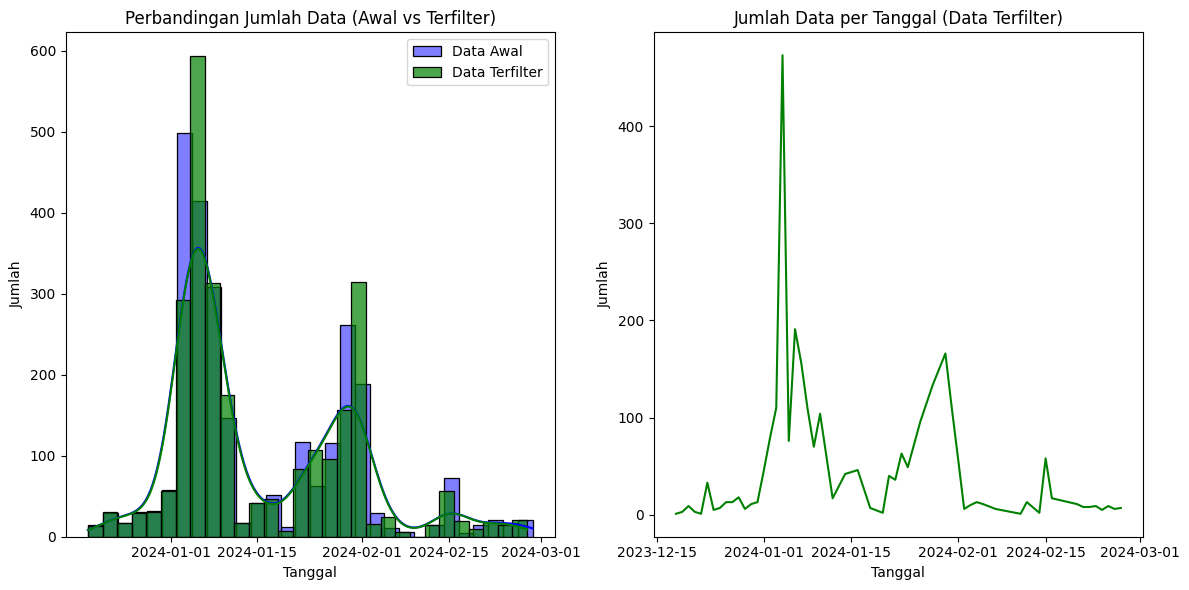

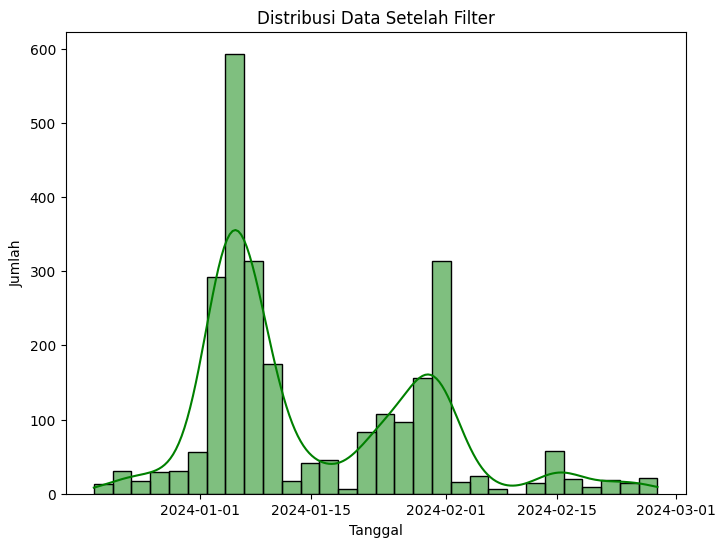

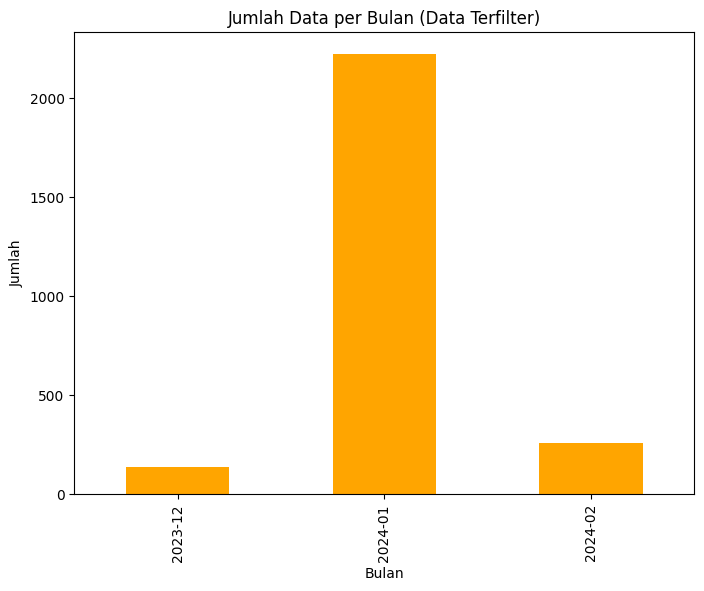

In [ ]:
# Create a plot comparing data before and after filtering
plt.figure(figsize=(12, 6))

# Plot 1: Data Count before and after filtering
plt.subplot(1, 2, 1)
sns.histplot(df_initial['created_at'], bins=30, kde=True, color='blue', label='Data Awal')
sns.histplot(df['created_at'], bins=30, kde=True, color='green', label='Data Terfilter', alpha=0.7)
plt.title('Perbandingan Jumlah Data (Awal vs Terfilter)')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah')
plt.legend()

# Plot 2: Time Series Count of filtered data
plt.subplot(1, 2, 2)
df['created_at'].groupby(df['created_at'].dt.date).count().plot(kind='line', color='green')
plt.title('Jumlah Data per Tanggal (Data Terfilter)')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah')

# Show the plots
plt.tight_layout()
plt.show()

# Additional analysis: Show distribution of 'created_at' after filtering
plt.figure(figsize=(8, 6))
sns.histplot(df['created_at'], bins=30, kde=True, color='green')
plt.title('Distribusi Data Setelah Filter')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah')
plt.show()

# Additional analysis: Grouping by month (if relevant column exists)
df['month'] = df['created_at'].dt.to_period('M')
plt.figure(figsize=(8, 6))
df.groupby('month').size().plot(kind='bar', color='orange')
plt.title('Jumlah Data per Bulan (Data Terfilter)')
plt.xlabel('Bulan')
plt.ylabel('Jumlah')
plt.show()

In [ ]:
def clean_data(df):

    essential_columns = ['full_text', 'created_at']
    missing_columns = [col for col in essential_columns if col not in df.columns]

    if missing_columns:
        print(f"Missing columns: {missing_columns}")
        return df

    # Drop NaN and invalid rows
    df = df.dropna(subset=essential_columns)
    df = df[df['full_text'].str.strip().astype(bool)]  # Remove empty strings
    df = df.drop_duplicates(subset=['full_text'], keep='first')  # Drop duplicates
    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
    df = df.dropna(subset=['created_at'])  # Drop invalid datetime rows
    df['created_at'] = df['created_at'].dt.tz_localize(None)  # Remove timezone

    # Remove non-alphanumeric characters (invalid data)
    def contains_invalid_characters(text):
        invalid_characters_ratio = sum(1 for c in text if c.isdigit() or c in string.punctuation) / len(text)
        return invalid_characters_ratio > 0.5  # Remove rows with excessive invalid characters

    df = df[~df['full_text'].swifter.apply(contains_invalid_characters)]

    # Normalize text in the 'full_text' column
    def normalize_text(text):
        text = re.sub(r'@\S+', '', text)                   # Remove mentions
        text = re.sub(r'http\S+', '', text)                # Remove URLs
        text = re.sub(r'[^\x00-\x7F]+', '', text)          # Remove emojis
        text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)  # Remove punctuation
        text = re.sub(r'\b\w{1,2}\b', '', text)            # Remove short words
        text = re.sub(r'\s+', ' ', text).strip().lower()   # Normalize spaces and lowercase
        return text

    # Apply normalization using swifter
    df['full_text'] = df['full_text'].swifter.apply(normalize_text)

    return df.reset_index(drop=True)

# Clean the data
df = clean_data(df)

# Save cleaned data
df.to_csv('/content/drive/MyDrive/SkripsiFIX/processing/cleaned_data.csv', index=False)
df.to_excel('/content/drive/MyDrive/SkripsiFIX/processing/cleaned_data.xlsx', index=False)

Pandas Apply:   0%|          | 0/2588 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2588 [00:00<?, ?it/s]

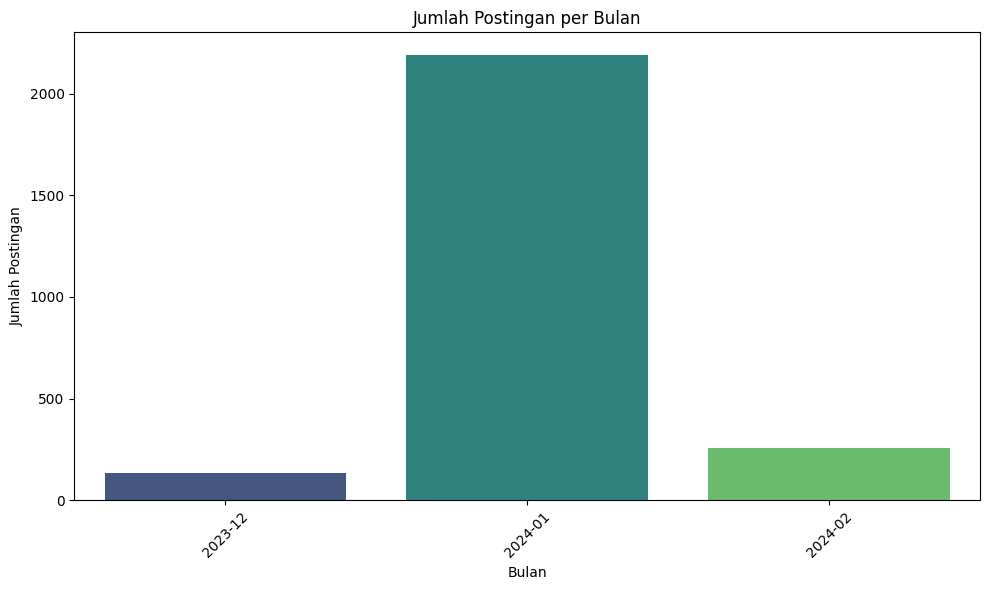

In [ ]:
# Convert 'created_at' to datetime if not already done
df['created_at'] = pd.to_datetime(df['created_at'])

# Extract year and month for grouping
df['year_month'] = df['created_at'].dt.to_period('M')

# Plot: Jumlah Postingan per Bulan
plt.figure(figsize=(10, 6))
sns.countplot(x='year_month', data=df, palette='viridis')
plt.title('Jumlah Postingan per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Postingan')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

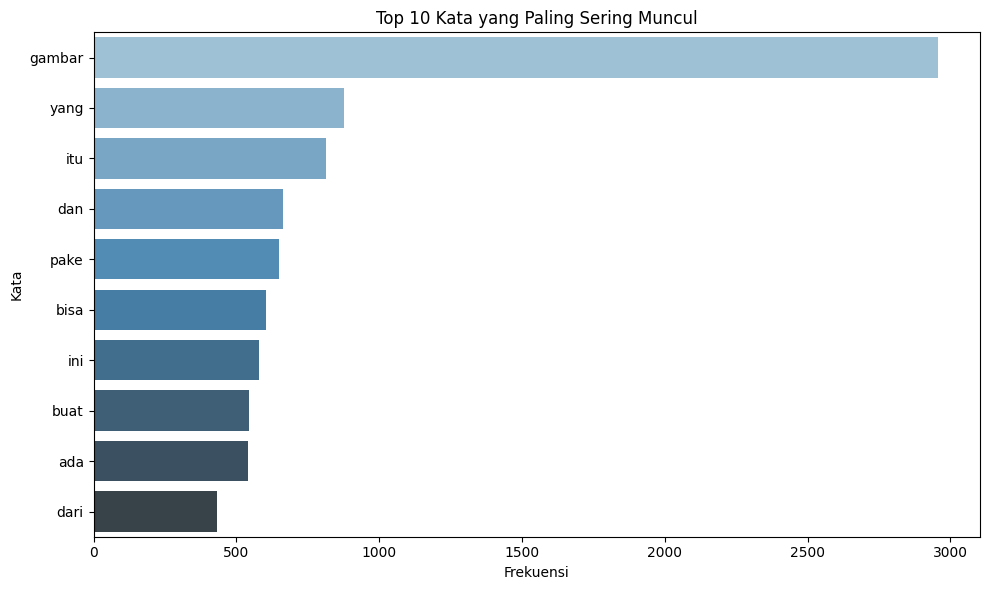

In [ ]:
# Tokenize words and remove stopwords/punctuation
def tokenize_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = text.split()
    return words

# Apply tokenization to 'full_text' column
all_words = sum(df['full_text'].apply(tokenize_text), [])
word_counts = Counter(all_words)

# Get the 10 most common words
common_words = word_counts.most_common(10)
words, counts = zip(*common_words)

# Plot: Top 10 kata paling sering
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words), palette='Blues_d')
plt.title('Top 10 Kata yang Paling Sering Muncul')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.tight_layout()
plt.show()

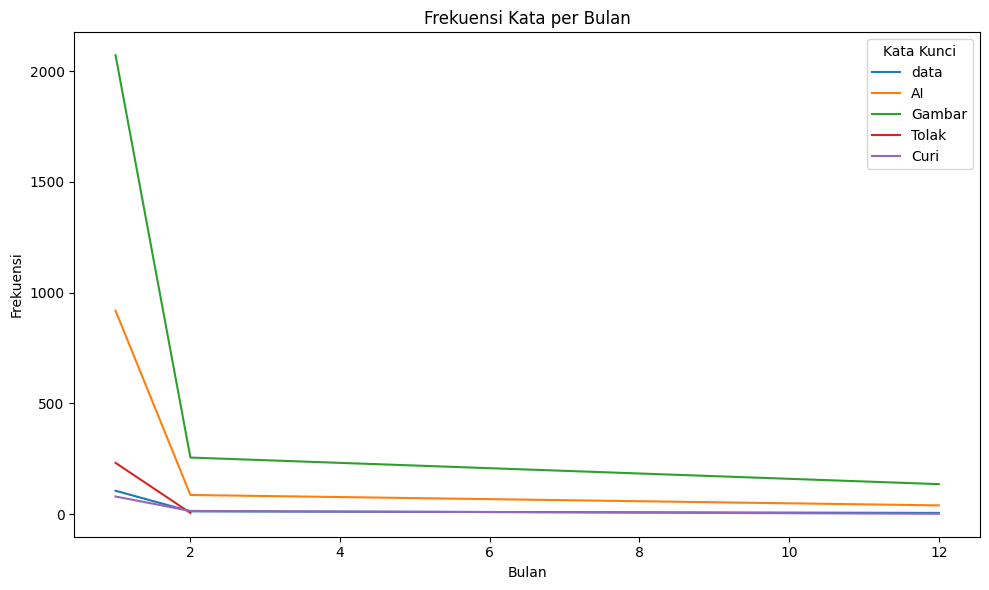

In [ ]:
# Extract month for grouping
df['month'] = df['created_at'].dt.month

# Define a list of keywords to track
keywords = ['data', 'AI', 'Gambar', 'Tolak', 'Curi']  # contoh kata kunci

# Count frequency of keywords per month
keyword_counts = {keyword: df[df['full_text'].str.contains(keyword, case=False)].groupby('month').size() for keyword in keywords}

# Plot: Frekuensi kata per bulan
plt.figure(figsize=(10, 6))
for keyword, counts in keyword_counts.items():
    plt.plot(counts.index, counts.values, label=keyword)

plt.title('Frekuensi Kata per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Frekuensi')
plt.legend(title='Kata Kunci')
plt.tight_layout()
plt.show()


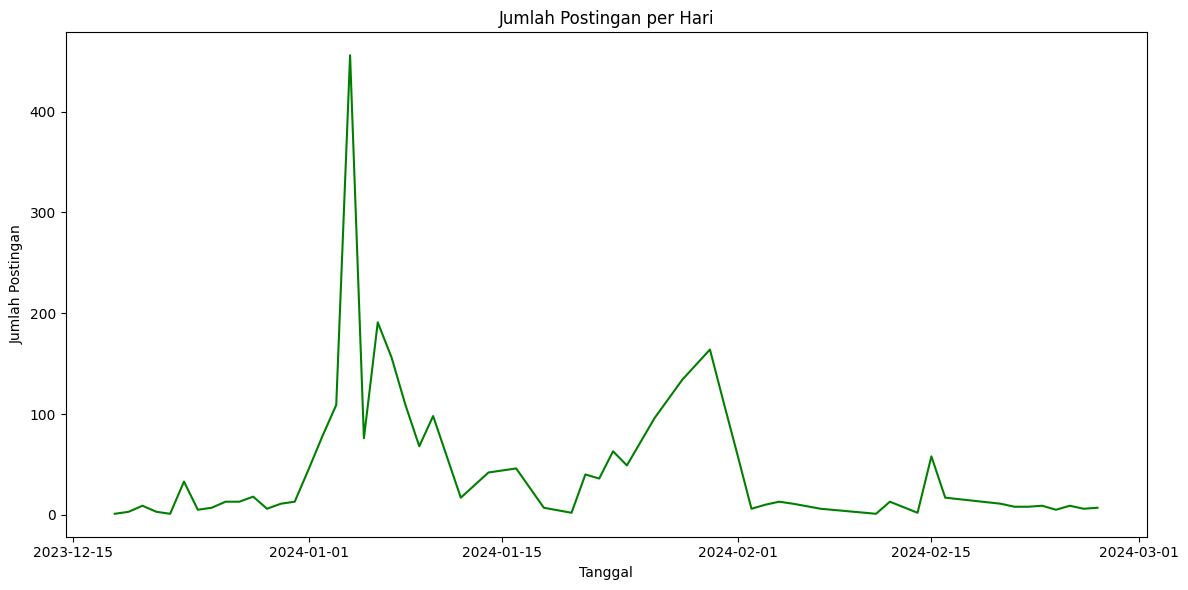

In [ ]:
# Extract date for grouping
df['date'] = df['created_at'].dt.date

# Plot: Jumlah Postingan per Hari
plt.figure(figsize=(12, 6))
df['date'].value_counts().sort_index().plot(kind='line', color='green')
plt.title('Jumlah Postingan per Hari')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Postingan')
plt.tight_layout()
plt.show()


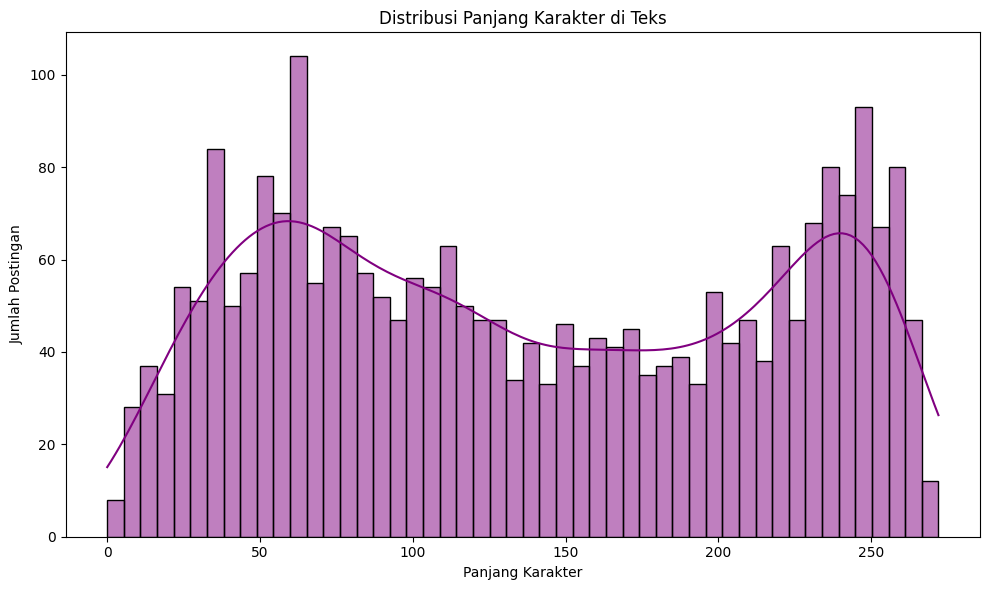

In [ ]:
# Calculate the length of each post's 'full_text'
df['text_length'] = df['full_text'].apply(len)

# Plot: Distribusi panjang karakter
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True, color='purple')
plt.title('Distribusi Panjang Karakter di Teks')
plt.xlabel('Panjang Karakter')
plt.ylabel('Jumlah Postingan')
plt.tight_layout()
plt.show()


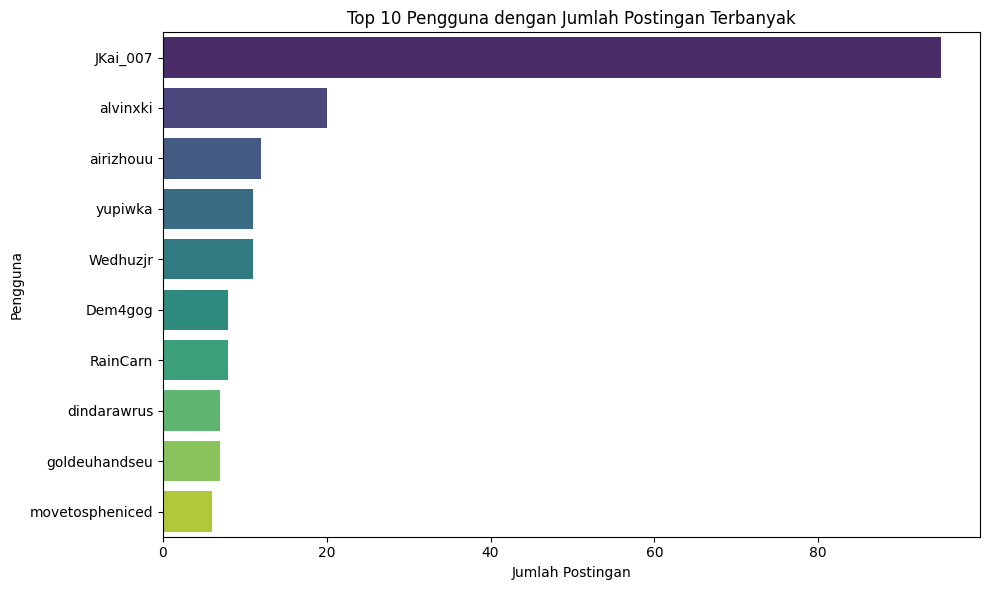

In [ ]:
# Count the number of posts per user (assuming there's a 'user' column)
user_counts = df['username'].value_counts().head(10)

# Plot: Top 10 Pengguna dengan Jumlah Postingan Terbanyak
plt.figure(figsize=(10, 6))
sns.barplot(x=user_counts.values, y=user_counts.index, palette='viridis')
plt.title('Top 10 Pengguna dengan Jumlah Postingan Terbanyak')
plt.xlabel('Jumlah Postingan')
plt.ylabel('Pengguna')
plt.tight_layout()
plt.show()


In [ ]:
# Cari username dengan jumlah postingan terbanyak
most_active_user = df['username'].value_counts().idxmax()

# Filter DataFrame hanya untuk postingan dari pengguna tersebut
most_active_user_posts = df[df['username'] == most_active_user]

# Tampilkan postingan dalam format yang lebih rapi
print(f"📌 Most Active User: {most_active_user}**\n")
print(f"Total Posts: {len(most_active_user_posts)}\n")
print("=" * 50)

for index, row in most_active_user_posts.iterrows():
    print(f"🗓️ Date: {row['created_at']}")
    print(f"📝 Post: {row['full_text']}")
    print("-" * 50)  # Pemisah antar postingan

📌 Most Active User: JKai_007**

Total Posts: 95

🗓️ Date: 2024-01-06 05:49:03
📝 Post: qrt with your eyes art style
--------------------------------------------------
🗓️ Date: 2024-01-06 07:37:32
📝 Post: shap laksanakan mulai menggambar bok
--------------------------------------------------
🗓️ Date: 2024-01-06 07:40:15
📝 Post: tolakgambarai
--------------------------------------------------
🗓️ Date: 2024-01-06 09:01:49
📝 Post: mau ikut qrt anak rambut putih dia jarang digambar bener heu
--------------------------------------------------
🗓️ Date: 2024-01-06 13:59:13
📝 Post: yudi dan yuda allah ngakak bgt
--------------------------------------------------
🗓️ Date: 2024-01-06 14:07:43
📝 Post: omg omg
--------------------------------------------------
🗓️ Date: 2024-01-06 16:38:14
📝 Post: nah pasti pasti bingungnya smpei turunan
--------------------------------------------------
🗓️ Date: 2024-01-06 16:38:39
📝 Post: thank youu
--------------------------------------------------
🗓️ Date: 2024-0

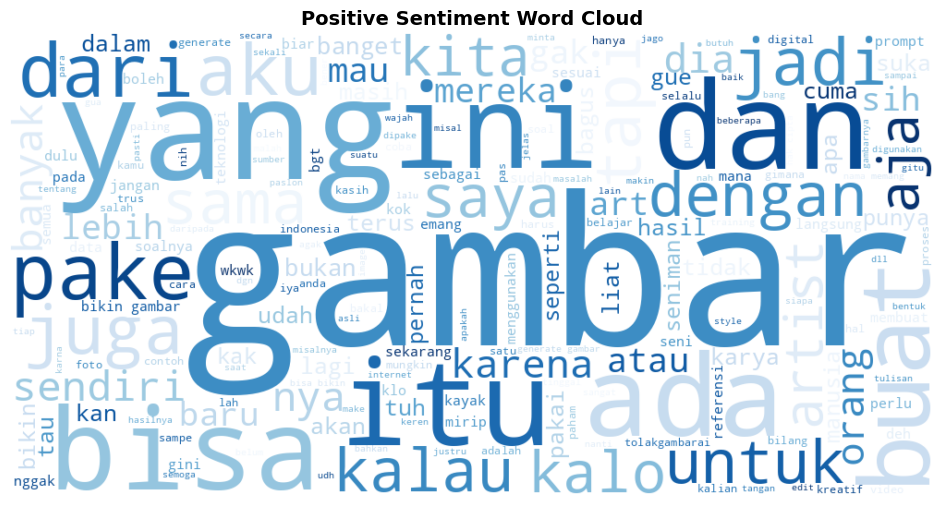

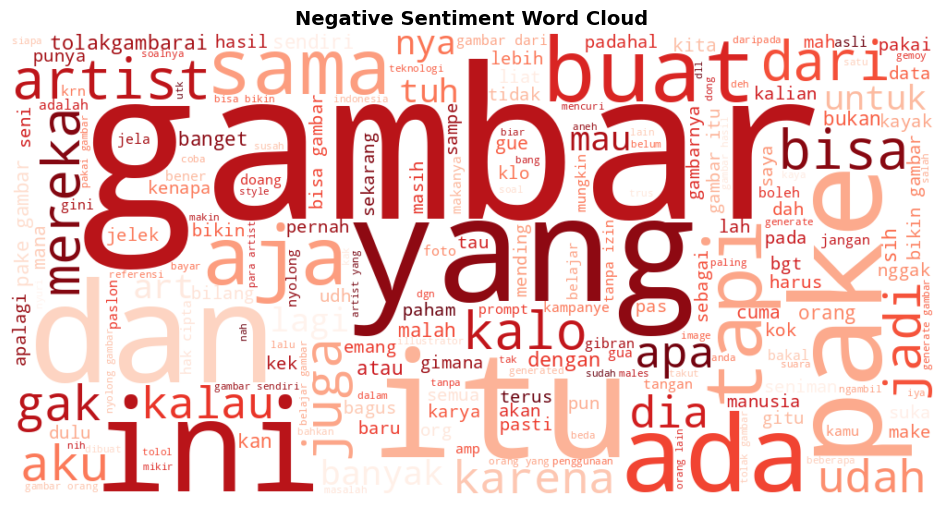

In [ ]:
# Fungsi untuk membuat dan menampilkan word cloud dengan warna lebih menarik
def plot_wordcloud(text_series, title, colormap='viridis'):
    text = ' '.join(text_series.astype(str))
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(
        width=1000, height=500,
        background_color='white',
        colormap=colormap,
        stopwords=stopwords,
        max_words=200,
        contour_color='steelblue', contour_width=2
    ).generate(text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=14, fontweight='bold')
    plt.show()

# Pisahkan ulasan berdasarkan sentimen
positive_reviews = df[df['Sentimen'] == 'Positive']['full_text']
negative_reviews = df[df['Sentimen'] == 'Negative']['full_text']

# Tampilkan word cloud
plot_wordcloud(positive_reviews, 'Positive Sentiment Word Cloud', colormap='Blues')
plot_wordcloud(negative_reviews, 'Negative Sentiment Word Cloud', colormap='Reds')


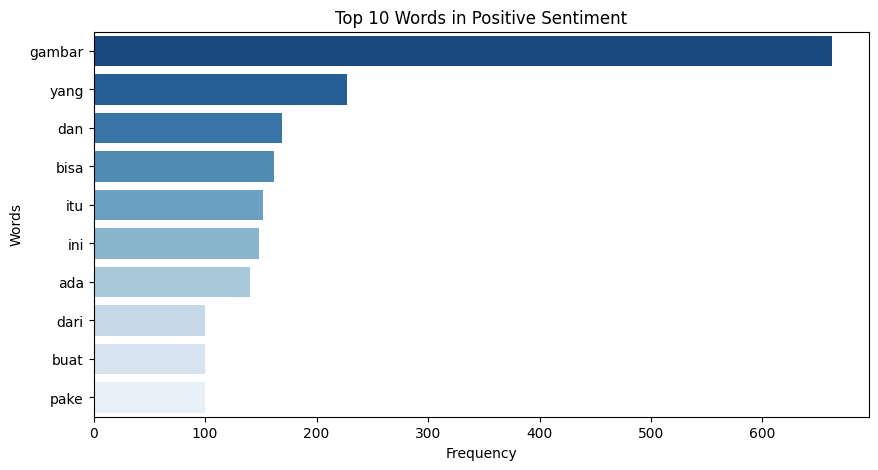

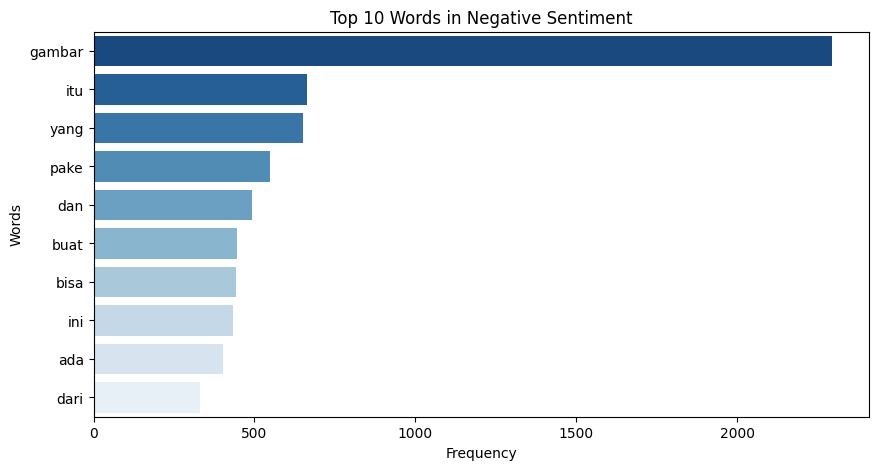

In [ ]:
def plot_top_words(text, title, num_words=10):
    words = ' '.join(text).split()
    word_freq = Counter(words)
    most_common_words = word_freq.most_common(num_words)

    words, counts = zip(*most_common_words)

    plt.figure(figsize=(10,5))
    sns.barplot(x=list(counts), y=list(words), palette="Blues_r")
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.title(f"Top {num_words} Words in {title}")
    plt.show()

plot_top_words(positive_reviews, "Positive Sentiment")
plot_top_words(negative_reviews, "Negative Sentiment")


In [ ]:
# Proper text preprocessing pipeline
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))

def clean_text(text):
    """Fixed stemming logic and stopword removal"""
    words = word_tokenize(text)
    # Added stemming validation
    cleaned_words = [stemmer.stem(word) for word in words
                     if word.lower() not in stop_words
                     and word.isalpha()
                     and len(word) > 2]  # Filter short stems
    return ' '.join(cleaned_words or [''])  # Handle empty texts

df['cleaned_text'] = df['full_text'].swifter.apply(clean_text)

Pandas Apply:   0%|          | 0/2588 [00:00<?, ?it/s]

In [ ]:
df['Sentimen']

,Sentimen
0,Negative
1,Negative
2,Negative
3,Negative
4,Negative
...,...
2583,Positive
2584,Negative
2585,Positive
2586,Negative


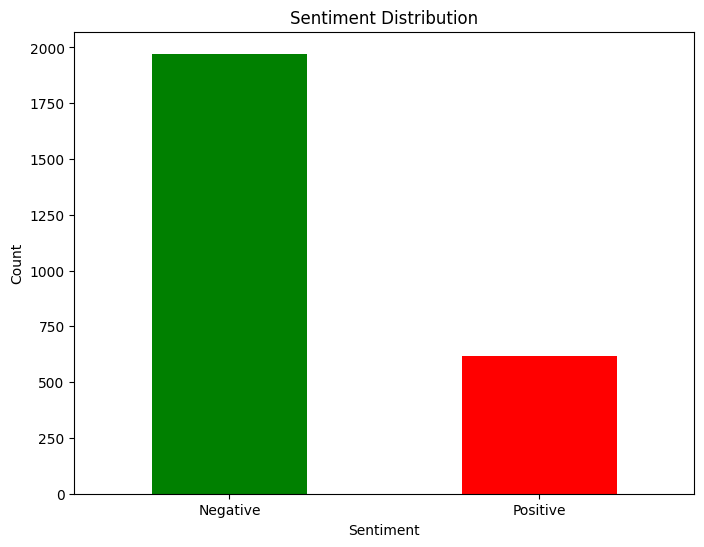

In [ ]:
# Count the occurrences of each sentiment category
sentiment_counts = df['Sentimen'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'gray'])  # Customize the colors as needed
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better visibility
plt.show()

In [ ]:
print("Jumlah NaN di cleaned_text:", df['cleaned_text'].isna().sum())
print("Jumlah NaN di Sentimen:", df['Sentimen'].isna().sum())

Jumlah NaN di cleaned_text: 0
Jumlah NaN di Sentimen: 0


In [ ]:
# Assuming 'df' is your DataFrame as defined in the provided code.
nan_sentiment_texts = df[df['Sentimen'].isna()]['full_text']

# Loop through each text and print it
for text in nan_sentiment_texts:
    print(text)


In [ ]:
X = df['cleaned_text']
y = df['Sentimen']

# Vectorize first before splitting
vectorizer = TfidfVectorizer()
X_vect = vectorizer.fit_transform(X)

# STRATIFIED split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_vect, y,
    test_size=0.2,
    stratify=y,  # Maintain class balance
    random_state=42
)

## Bagian 7.2: Panjang Text

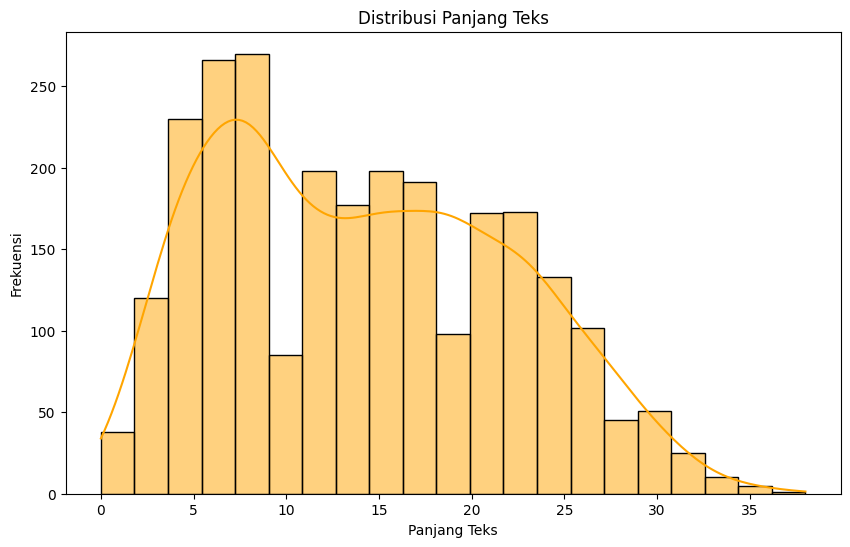

In [ ]:
df['Text_Length'] = df['cleaned_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['Text_Length'], kde=True, color='orange')
plt.title('Distribusi Panjang Teks')
plt.xlabel('Panjang Teks')
plt.ylabel('Frekuensi')
plt.show()

In [ ]:
# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
# Model training with proper hyperparameter tuning
svm_model = SVC(class_weight='balanced', probability=True, random_state=42)
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale']}

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Create a Stratified KFold cross-validator
stratified_kfold = StratifiedKFold(n_splits=5)

# Use the StratifiedKFold in the GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=stratified_kfold, scoring='f1_weighted')

# Fit the model to the training data
grid_search.fit(X_train_smote, y_train_smote)

# To check the best parameters and best score found during the search
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.9032920028716166


In [ ]:
# Use best model directly on original test data (no PCA distortion)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

              precision    recall  f1-score   support

     Negatif       0.77      0.99      0.87       395
     Positif       0.67      0.05      0.09       123

    accuracy                           0.77       518
   macro avg       0.72      0.52      0.48       518
weighted avg       0.75      0.77      0.68       518



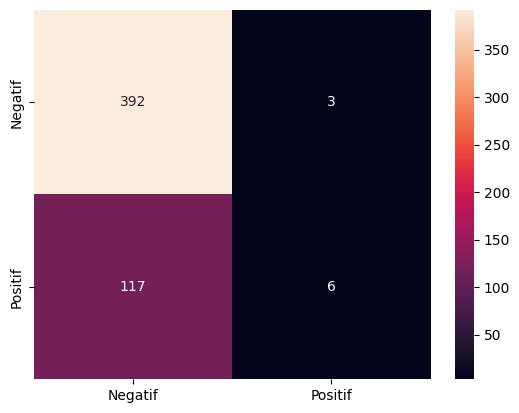

In [ ]:
# Confusion Matrix with ALL CLASSES
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=['Negatif', 'Positif'],
            yticklabels=['Negatif', 'Positif'])

# Classification Report with label names
print(classification_report(y_test, y_pred,
                            target_names=['Negatif', 'Positif']))


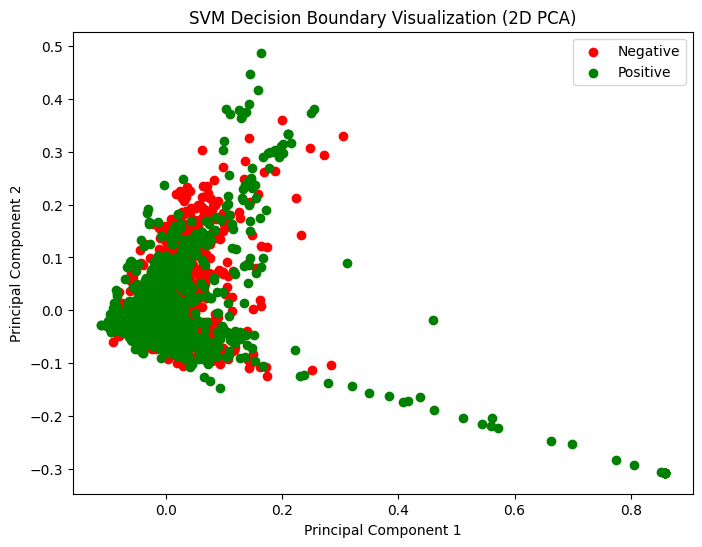

In [ ]:
# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_smote)

# Plot the data points
plt.figure(figsize=(8, 6))
for target, color in zip(np.unique(y_train_smote), ['red', 'green']):
    plt.scatter(X_train_pca[y_train_smote == target, 0],
                X_train_pca[y_train_smote == target, 1],
                label=target, c=color)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVM Decision Boundary Visualization (2D PCA)')
plt.legend()
plt.show()


ROC AUC (Binary): 0.7692909334156632


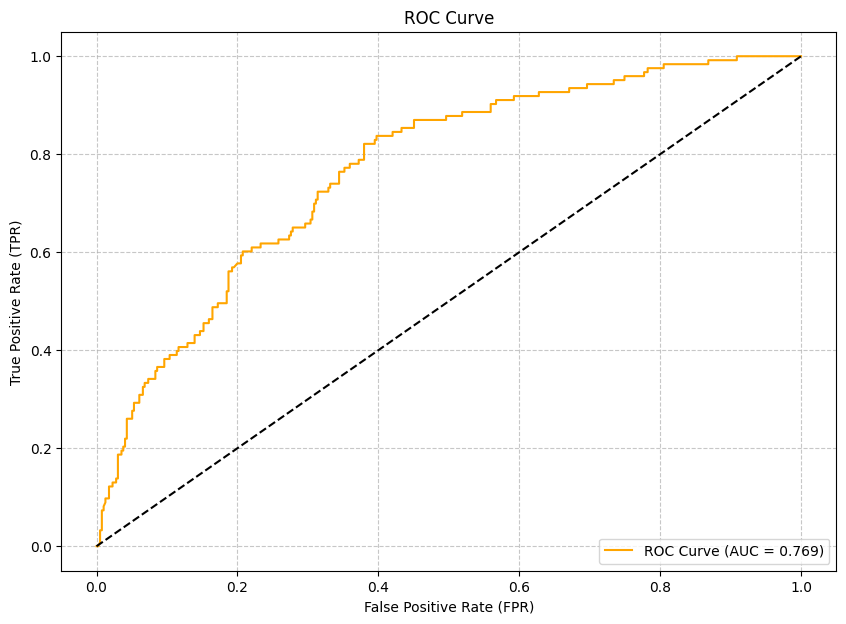

In [ ]:
# === Konversi label string ke numerik ===
label_map = {'Positive': 1, 'Negative': 0}
y_test_numeric = np.array([label_map[label] for label in y_test])

# Dapatkan probabilitas untuk setiap kelas
y_prob = best_model.predict_proba(X_test)

plt.figure(figsize=(10, 7))

# === Jika klasifikasi BINARY ===
if len(np.unique(y_test_numeric)) == 2:
    # ROC AUC Score
    roc_auc = roc_auc_score(y_test_numeric, y_prob[:, 1])
    print(f"ROC AUC (Binary): {roc_auc}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test_numeric, y_prob[:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})', color='orange')

# === Jika klasifikasi MULTI-CLASS ===
else:
    y_test_multi = label_binarize(y_test_numeric, classes=np.unique(y_test_numeric))
    n_classes = y_test_multi.shape[1]

    roc_auc_scores = roc_auc_score(y_test_multi, y_prob, average=None, multi_class='ovr')
    roc_auc_macro = roc_auc_score(y_test_multi, y_prob, average='macro', multi_class='ovr')

    print(f"ROC AUC scores for each class: {roc_auc_scores}")
    print(f"Macro-averaged ROC AUC: {roc_auc_macro}")

    colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))
    for i, color in zip(range(n_classes), colors):
        fpr, tpr, _ = roc_curve(y_test_multi[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, color=color, label=f'Class {i} (AUC = {roc_auc_scores[i]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', label=f'Macro Avg (AUC = {roc_auc_macro:.3f})', alpha=0.7)

# === Tambahkan Label dan Title ===
plt.plot([0, 1], [0, 1], 'k--')  # Garis diagonal
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


Optimal Threshold berdasarkan ROC Curve: 0.08266932958135519
Confusion Matrix (Threshold Optimal):
[[245 150]
 [ 22 101]]

Classification Report:
              precision    recall  f1-score   support

     Negatif       0.92      0.62      0.74       395
     Positif       0.40      0.82      0.54       123

    accuracy                           0.67       518
   macro avg       0.66      0.72      0.64       518
weighted avg       0.80      0.67      0.69       518



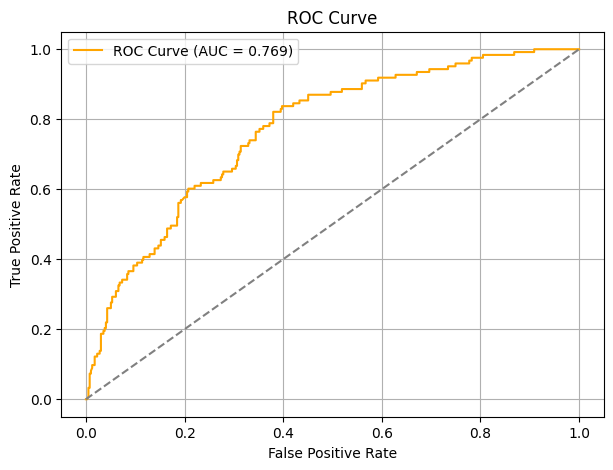

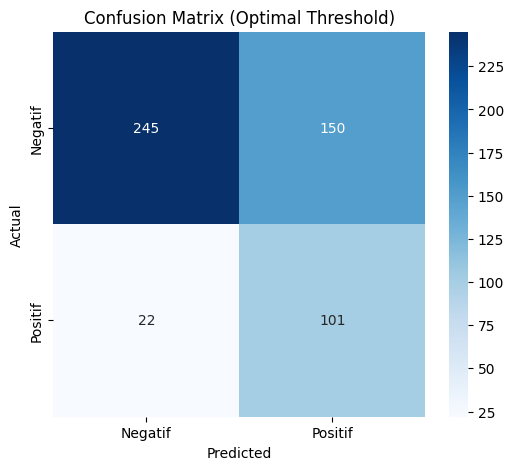

In [ ]:
# 1. Model Training & Hyperparameter Tuning (GridSearchCV + Stratified K-Fold)
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Ensure binary labels for ROC curve
y_test_binary = np.where(y_test == 'Positive', 1, 0)

# Model Training with GridSearchCV and StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(svm_model, param_grid, cv=stratified_kfold, scoring='f1_weighted')
grid_search.fit(X_train_smote, y_train_smote)

best_model = grid_search.best_estimator_
y_prob = best_model.predict_proba(X_test)[:, 1]

# 2. Threshold Optimization via ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_prob)
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold berdasarkan ROC Curve: {optimal_threshold}")

# 3. Final Evaluation with Optimal Threshold
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)
cm = confusion_matrix(y_test_binary, y_pred_optimal)
print("Confusion Matrix (Threshold Optimal):")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_optimal, target_names=['Negatif', 'Positif']))

# Plot ROC Curve
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test_binary, y_prob):.3f})', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Optimal Threshold)')
plt.show()
